In [15]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import plotly.express as px

In [16]:
# Load the transactional data
df = pd.read_excel('transactional_data.xlsx', parse_dates=['Date'])
df.head()

,InvoiceNo,Date,CustomerID,CustomerName,StockCode,Description,Quantity,UnitPrice,TotalAmount
0,44671292,2022-04-20,292,Shruti,NaN,Cheese Corn Bomb (Plate),1.0,140,140.0
1,44671292,2022-04-20,292,Shruti,NaN,Gool Poli (Plate),1.0,180,180.0
2,44671292,2022-04-20,292,Shruti,NaN,Puran Poli (Plate),1.0,180,180.0
3,44672118,2022-04-21,118,Mahapatra,NaN,Jowar Bhakri,2.0,42,84.0
4,44678192,2022-04-27,192,Pranesh,NaN,Chicken Thali,2.0,300,600.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   InvoiceNo     805 non-null    int64         
 1   Date          805 non-null    datetime64[ns]
 2   CustomerID    805 non-null    int64         
 3   CustomerName  805 non-null    object        
 4   StockCode     0 non-null      float64       
 5   Description   805 non-null    object        
 6   Quantity      805 non-null    float64       
 7   UnitPrice     805 non-null    int64         
 8   TotalAmount   805 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 56.7+ KB


In [18]:
# Calculate Recency, Frequency and Monetary Value for each customer

rfm_table = df.groupby(['CustomerID']).agg({
    'Date': lambda x: (x.max() - x.min()).days,
    'InvoiceNo': pd.Series.nunique,
    'TotalAmount': 'sum'})
rfm_table.head(10)

,Date,InvoiceNo,TotalAmount
CustomerID,,,
1,0,1,350.0
2,81,3,12530.0
3,215,3,6725.0
4,0,1,204.0
5,1,2,231.0
6,0,1,65.0
7,0,1,82.0
8,0,1,180.0
9,0,1,84.0


In [19]:
# Rename the columns
rfm_table.rename(columns={'Date': 'Recency',
                          'InvoiceNo': 'Frequency',
                          'TotalAmount': 'MonetaryValue'}, inplace=True)
rfm_table.head(10)

,Recency,Frequency,MonetaryValue
CustomerID,,,
1,0,1,350.0
2,81,3,12530.0
3,215,3,6725.0
4,0,1,204.0
5,1,2,231.0
6,0,1,65.0
7,0,1,82.0
8,0,1,180.0
9,0,1,84.0


In [20]:
# Perform normalization on RFM scores as the scores may have different scales and ranges that could bias the clustering results
scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm_table)
rfm_normalized = pd.DataFrame(rfm_scaled, columns=rfm_table.columns, index=rfm_table.index)
rfm_normalized.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
1,0.000000,0.0,0.026379
2,0.300000,0.4,1.000000
3,0.796296,0.4,0.535971
4,0.000000,0.0,0.014708
5,0.003704,0.2,0.016867


In [21]:
rfm_normalized['Recency'] = 1 - rfm_normalized['Recency']
rfm_normalized.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
1,1.000000,0.0,0.026379
2,0.700000,0.4,1.000000
3,0.203704,0.4,0.535971
4,1.000000,0.0,0.014708
5,0.996296,0.2,0.016867


In [22]:
# Perform hierarchical clustering using linkage matrix and dendogram
linkage_matrix = linkage(rfm_normalized, method='ward')

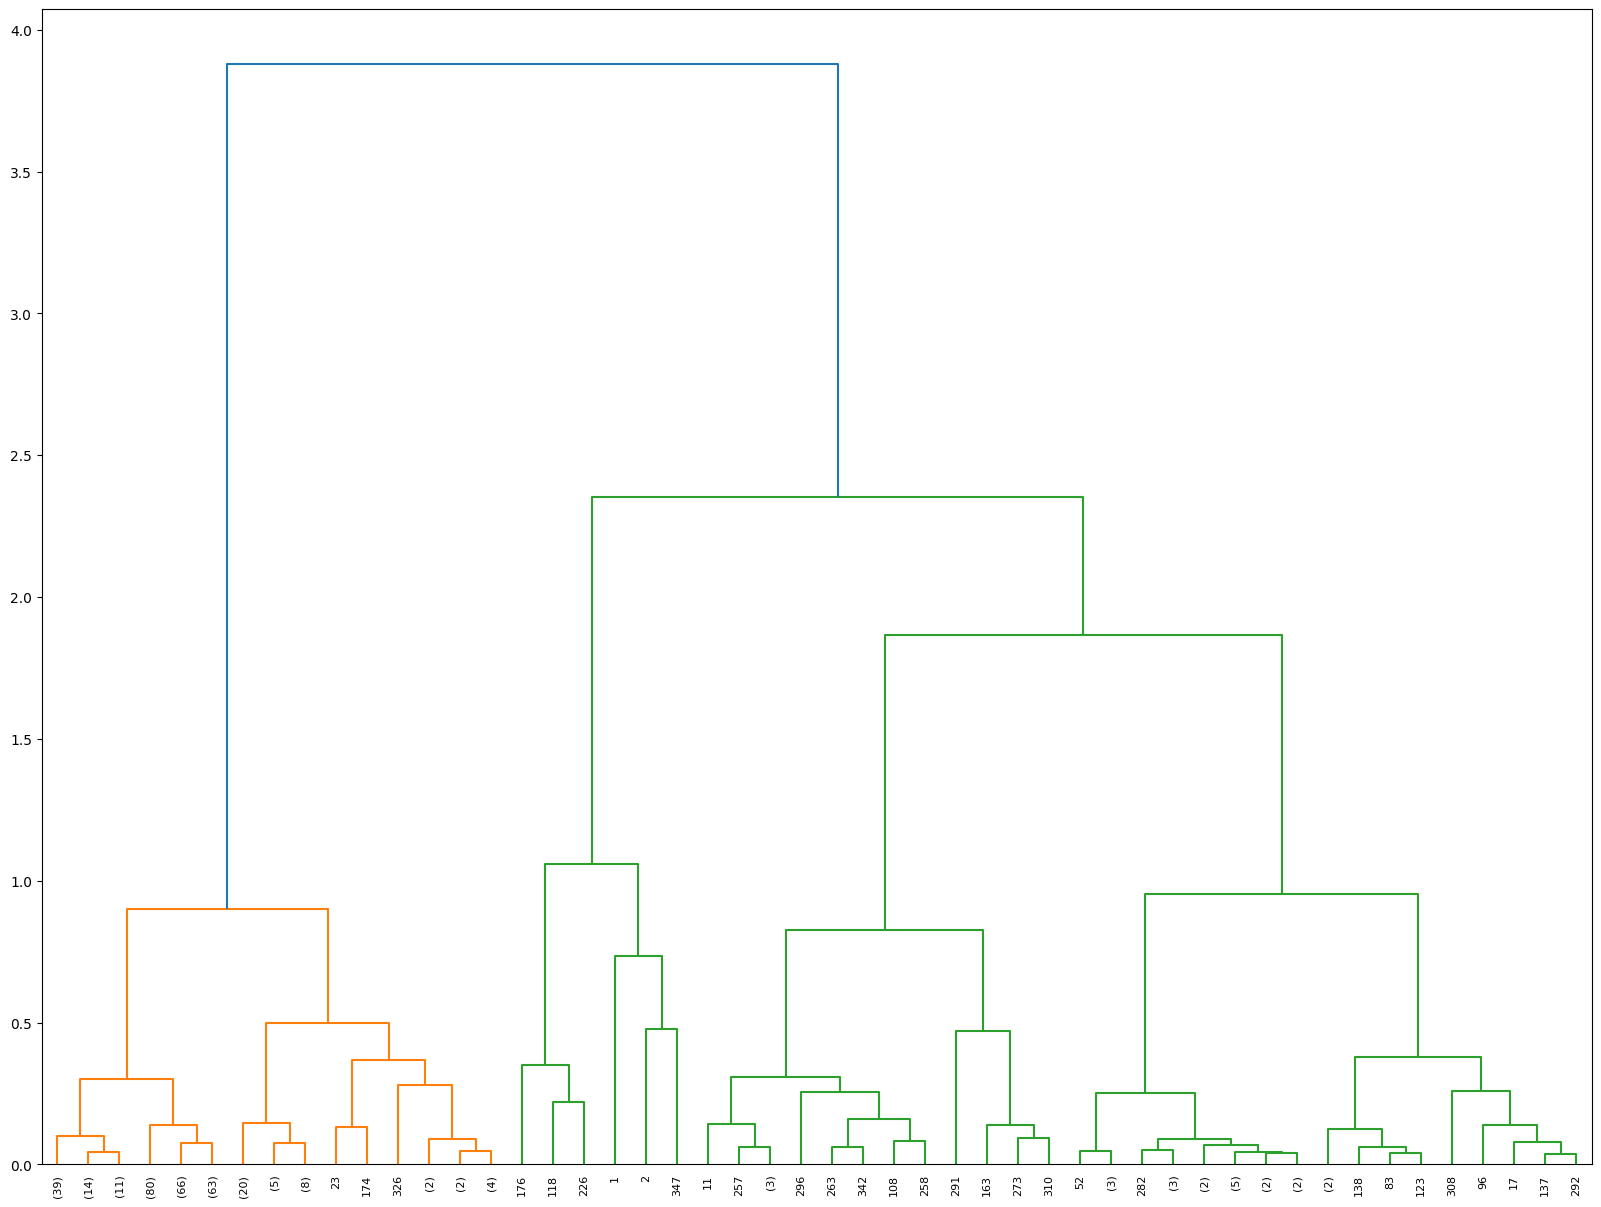

In [23]:
# Plot the dendrogram to determine the number of clusters
plt.figure(figsize=(20, 15))
dendrogram(linkage_matrix, p=50, truncate_mode='lastp', show_leaf_counts=True)
plt.show()

In [24]:
# Cut the dendrogram to obtain the clusters
clusters = fcluster(linkage_matrix, t=4, criterion='maxclust')
rfm_normalized['Cluster'] = clusters
rfm_normalized.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
1,1.000000,0.0,0.026379,1
2,0.700000,0.4,1.000000,2
3,0.203704,0.4,0.535971,2
4,1.000000,0.0,0.014708,1
5,0.996296,0.2,0.016867,4


In [25]:
# Create a 3D scatter plot of the RFM data
fig = px.scatter_3d(rfm_normalized, x='Recency', y='Frequency', z='MonetaryValue', color='Cluster', 
                    opacity=0.8, width=800, height=800)
fig.update_layout(scene=dict(xaxis_title='Recency', yaxis_title='Frequency', zaxis_title='Monetary Value'))
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed